[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/DSSM/DSSM.ipynb)

> This notebook runs DSSM for candidate generation on MovieLens1M dataset. 

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

## Table of Contents:
* [Prepare data for retrieval](#section-0)
* [Train retrieve model and export embeddings](#section-1)
* [Use Faiss to generate candidates](#section-2)

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! cd HandyRec && python setup.py install
! pip install faiss-gpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 2062, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 2062 (delta 116), reused 164 (delta 76), pack-reused 1803
Receiving objects: 100% (2062/2062), 22.87 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (871/871), done.
running install
running bdist_egg
running egg_info
creating handyrec.egg-info
writing handyrec.egg-info/PKG-INFO
writing dependency_links to handyrec.egg-info/dependency_links.txt
writing requirements to handyrec.egg-info/requires.txt
writing top-level names to handyrec.egg-info/top_level.txt
writing manifest file 'handyrec.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'handyrec.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/handyrec
copying handyrec/config.py -> build/lib/handyrec
copying handyrec/

**Note: Restart the kernel after installing `handyrec`**

In [2]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-05-24 14:08:24--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  3.44MB/s    in 1.6s    

2022-05-24 14:08:27 (3.44 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [1]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import PointWiseDataset

from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.models.retrieval import DSSM
from handyrec.config import ConfigLoader
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
BATCH_SIZE = 2**12
NEPOCH = 50

TEST_NUM = 10
VALID_RATIO = 0.1

**Load MovieLens1M data**

In [4]:
dh = MovielensDataHelper('./ml-1m/')
data = dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', seq_len=40)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:05<00:00, 1189.29it/s]


# 0. Prepare data for retrieval<a name="section-0"></a>

In [5]:
user_features = ['user_id', 'gender', 'occupation']
item_features = ['movie_id','genres']
inter_features = ['hist_movie']

In [6]:
retrieval_dataset = PointWiseDataset(
    "RetrievalDataset",
    task="retrieval",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

retrieval_dataset.train_test_split(TEST_NUM)
retrieval_dataset.train_valid_split(VALID_RATIO)
retrieval_dataset.gen_dataset(user_features, item_features, inter_features, shuffle=False)

Save inter features: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


In [7]:
train_data, valid_data, test_data, test_label = retrieval_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE
)

Load inter features: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


In [10]:
feature_dim = retrieval_dataset.get_feature_dim(user_features, item_features, [])
feature_dim["genre_id"] = 19

# 1. Train retrieve model and export embeddings <a name="section-1"></a>

In [11]:
cfg = ConfigLoader("./HandyRec/examples/DSSM/DSSM_cfg.yaml")
feature_groups = cfg.prepare_features(feature_dim, data)

In [12]:
retrieve_model = DSSM(
    feature_groups["user_feature_group"],
    feature_groups["item_feature_group"],
    **cfg.config.Model
)

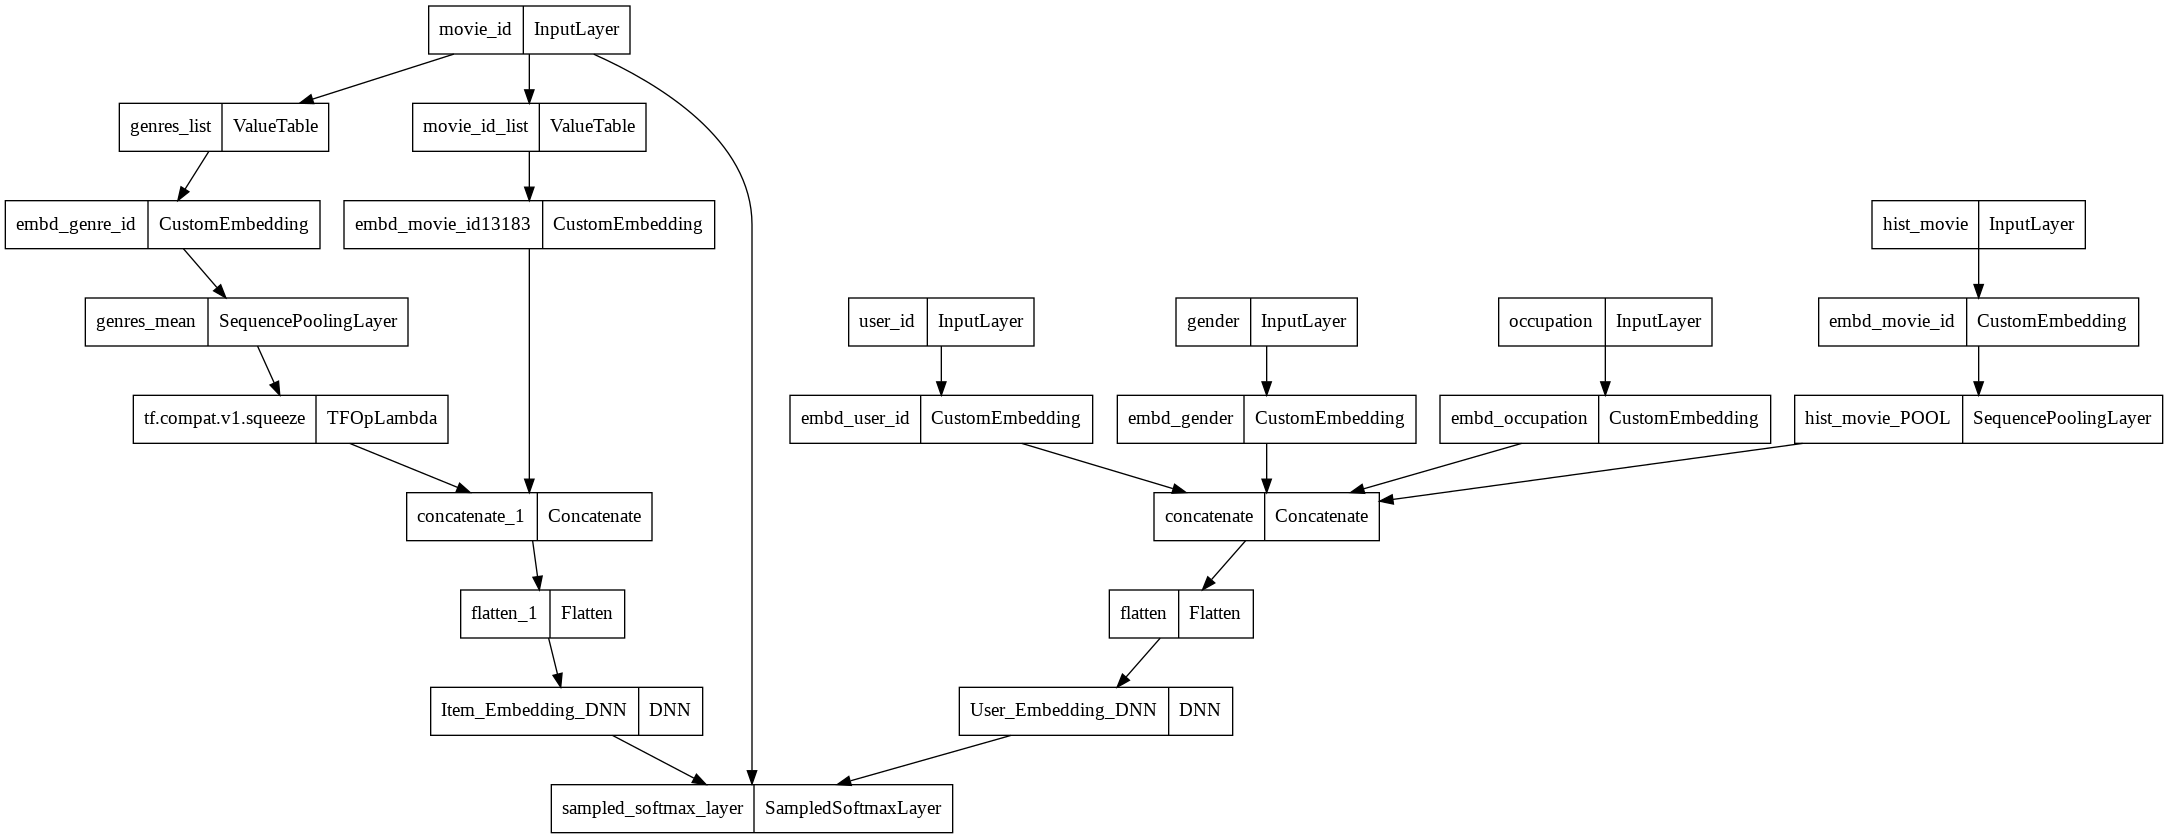

In [13]:
plot_model(retrieve_model)

In [14]:
retrieve_model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./retrieve_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = retrieve_model.fit(
    x=train_data,
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop, checkpoint],
)

Epoch 1/50
114/114 [==============================] - 10s 33ms/step - loss: 9.6389 - val_loss: 3.9083
Epoch 2/50
114/114 [==============================] - 4s 30ms/step - loss: 5.1051 - val_loss: 3.8766
Epoch 3/50
114/114 [==============================] - 3s 29ms/step - loss: 4.3597 - val_loss: 3.7763
Epoch 4/50
114/114 [==============================] - 4s 31ms/step - loss: 4.0069 - val_loss: 3.6604
Epoch 5/50
114/114 [==============================] - 3s 30ms/step - loss: 3.7518 - val_loss: 3.3459
Epoch 6/50
114/114 [==============================] - 3s 29ms/step - loss: 3.4781 - val_loss: 2.9889
Epoch 7/50
114/114 [==============================] - 3s 30ms/step - loss: 3.3026 - val_loss: 2.9007
Epoch 8/50
114/114 [==============================] - 3s 29ms/step - loss: 3.0857 - val_loss: 2.6749
Epoch 9/50
114/114 [==============================] - 3s 29ms/step - loss: 2.9921 - val_loss: 2.4926
Epoch 10/50
114/114 [==============================] - 3s 30ms/step - loss: 2.8733 - val_l

In [15]:
retrieve_model.load_weights('./retrieve_checkpoint/')

In [16]:
user_embedding_model = Model(inputs=retrieve_model.user_input, outputs=retrieve_model.user_embedding)
item_embedding_model = Model(inputs=retrieve_model.item_input, outputs=retrieve_model.item_embedding)

user_embs = user_embedding_model.predict(test_data, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(feature_groups["value_dict"], batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(5923, 32)
(3883, 32)


# 2. Use Faiss to generate candidates <a name="section-2"></a>

## Test retrieve model

In [17]:
candidates = search_embedding(
    32, item_embs, user_embs, data["item"]["movie_id"].values, 100, gpu=True
)

In [18]:
map_at_k(test_label, candidates, k=10)

0.012198538653460147

In [19]:
recall_at_k(test_label, candidates, k=10)

0.03248353874725646

In [20]:
recall_at_k(test_label, candidates, k=100)

0.1407732567955428